## 分析A/B测试结果



## 目录
- [简介](#intro)
- [I - 概率](#probability)
- [II - A/B 测试](#ab_test)
- [III - 回归](#regression)


<a id='intro'></a>
### 简介


对于这个项目，要了解的是电子商务网站运行的 A/B 测试的结果。通过这个 notebook 来帮助公司弄清楚他们是否应该使用新的页面，保留旧的页面，或者应该将测试时间延长，之后再做出决定。

<a id='probability'></a>
#### I - 概率


In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` 现在，导入 `ab_data.csv` 数据，并将其存储在 `df` 中。 

a. 导入数据集，并在这里查看前几行：

In [2]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. 使用下面的单元格来查找数据集中的行数。

In [3]:
df.shape

(294478, 5)

c. 数据集中独立用户的数量。

In [4]:
df['user_id'].nunique()

290584

d. 用户转化的比例。

In [5]:
df_c = df.groupby('converted').user_id
df_c.nunique()

converted
0    256275
1     35173
Name: user_id, dtype: int64

In [6]:
#用户转化率
35173/290584

0.12104245244060237

e.  `new_page` 与 `treatment` 不一致的次数。

In [7]:
 df.groupby(['group', 'landing_page'])['user_id'].count()

group      landing_page
control    new_page          1928
           old_page        145274
treatment  new_page        145311
           old_page          1965
Name: user_id, dtype: int64


f. 是否有任何行存在缺失值？

In [8]:
df.isnull().sum().any()

False

`2.` 对于 **treatment** 不与 **new_page** 一致的行或 **control** 不与 **old_page** 一致的行，我们不能确定该行是否真正接收到了新的或旧的页面。我们应该如何处理这些行？在课堂中的 **测试 2** 中，给出你的答案。  

a. 现在，使用测试题的答案创建一个符合测试规格要求的新数据集。将新 dataframe 存储在 **df2** 中。

In [9]:
df2 = df[((df.group == 'treatment') & (df.landing_page == 'new_page')) | ((df.group == 'control') & (df.landing_page == 'old_page'))]

In [10]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

In [11]:
df2[((df2['group'] == 'control') == (df2['landing_page'] == 'old_page')) == False].shape[0]

0

`3.` 使用 **df2** 与下面的单元格来回答课堂中的 **测试3** 。

a.  **df2** 中有多少唯一的 **user_id**?

In [12]:
df2['user_id'].nunique()

290584

b.  **df2** 中有一个重复的 **user_id** 。它是什么？ 

In [13]:
df2.groupby('user_id').size().idxmax()

773192

c. 这个重复的  **user_id** 的行信息是什么？

In [14]:
df2[df2['user_id'] == 773192]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. 删除 **一个** 含有重复的 **user_id** 的行， 但需要确保你的 dataframe 为 **df2**。

In [15]:
df2.drop_duplicates('user_id', inplace=True)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


`4.` 在下面的单元格中，使用 **df2** 来回答与课堂中的 **测试 4** 相关的测试题目。

a. 不管它们收到什么页面，单个用户的转化率是多少？


In [16]:
df2.groupby('converted').user_id.count()

converted
0    255831
1     34753
Name: user_id, dtype: int64

In [17]:
34753/290584

0.11959708724499628

b. 假定一个用户处于 `control` 组中，他的转化率是多少？

In [18]:
df2.groupby(['group', 'converted'], as_index=False)['user_id'].count()

,group,converted,user_id
0,control,0,127785
1,control,1,17489
2,treatment,0,128046
3,treatment,1,17264


In [19]:
p_ctr = 17489/(127785 + 17489)
p_ctr

0.1203863045004612

c. 假定一个用户处于 `treatment` 组中，他的转化率是多少？


In [20]:
p_tre = 17264/(128046 + 17264)
p_tre

0.11880806551510564

d. 一个用户收到新页面的概率是多少？


In [21]:
df2.groupby(['landing_page'])['user_id'].count()

landing_page
new_page    145310
old_page    145274
Name: user_id, dtype: int64

In [22]:
145310/290584

0.5000619442226688

e. 使用这个问题的前两部分的结果，给出你的建议：你是否认为有证据表明一个页面可以带来更多的转化？

采用总体来分析的情况下，control组的转化率为0.1204，而treatment组的转化率为0.1188，差异并不明显，不能由此说明某一个页面可以带来更多的转化率。

<a id='ab_test'></a>
### II - A/B 测试


`1.` 现在，要考虑的是，你需要根据提供的所有数据做出决定。如果你想假定旧的页面效果更好，除非新的页面在类型I错误率为5％的情况下才能证明效果更好，那么，你的零假设和备择假设是什么？ 你可以根据单词或旧页面与新页面的转化率 **$p_{old}$** 与 **$p_{new}$** 来陈述你的假设。


H0: p_old - p_new >= 0

H1: p_old - p_new < 0

`2.` 假定在零假设中，不管是新页面还是旧页面， $p_{new}$ and $p_{old}$ 都具有等于 **转化** 成功率的“真”成功率，也就是说，  $p_{new}$ 与 $p_{old}$ 是相等的。此外，假设它们都等于**ab_data.csv** 中的 **转化** 率，新旧页面都是如此。  <br><br>

每个页面的样本大小要与 **ab_data.csv** 中的页面大小相同。  <br><br>

执行两次页面之间 **转化** 差异的抽样分布，计算零假设中10000次迭代计算的估计值。  <br><br>


a. 在零假设中，$p_{new}$ 的 **convert rate（转化率）** 是多少？


In [23]:
p_new = 0.1196

b. 在零假设中， $p_{old}$  的 **convert rate（转化率）** 是多少？ <br><br>

In [24]:
p_old = 0.1196

c.  $n_{new}$ 是多少？

In [25]:
n_new = 145310

d.  $n_{old}$?是多少？

In [26]:
n_old = 145274

e. 在零假设中，使用 $p_{new}$ 转化率模拟 $n_{new}$ 交易，并将这些 $n_{new}$ 1's 与 0's 存储在 **new_page_converted** 中。

In [27]:
new_page_converted = np.random.choice([0,1], n_new, p=[0.8804,0.1196])

f. 在零假设中，使用 $p_{old}$ 转化率模拟 $n_{old}$ 交易，并将这些  $n_{old}$ 1's 与 0's 存储在 **old_page_converted** 中。

In [28]:
old_page_converted = np.random.choice([0,1], n_old, p=[0.8804,0.1196])

g. 在 (e) 与 (f)中找到 $p_{new}$ - $p_{old}$ 模拟值。

In [29]:
p_new = new_page_converted.mean()
p_old = old_page_converted.mean()
diff = p_new - p_old 

h. 使用**a. 到 g. ** 中的计算方法来模拟 10,000个 $p_{new}$ - $p_{old}$ 值，并将这 10,000 个值存储在 **p_diffs** 中。

In [30]:
p_diffs = []
for _ in range(10000):
    new_page_converted = np.random.choice([0,1], n_new, p=[0.8804,0.1196])
    old_page_converted = np.random.choice([0,1], n_old, p=[0.8804,0.1196])
    p_new = new_page_converted.mean()
    p_old = old_page_converted.mean()
    p_diffs.append(p_new - p_old)

i. 绘制一个 **p_diffs** 直方图。

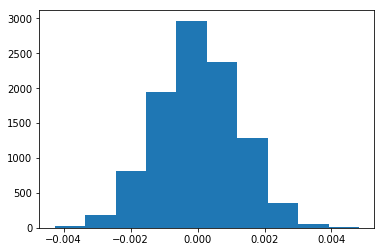

In [31]:
p_diffs = np.array(p_diffs)
plt.hist(p_diffs);

j.  在**p_diffs**列表的数值中，有多大比例大于 **ab_data.csv** 中观察到的实际差值？

In [32]:
obs_diff = p_tre - p_ctr
(p_diffs > obs_diff).mean()

0.90400000000000003

k. 用文字解释一下你刚才在 **j.**中计算出来的结果。在科学研究中，这个值是什么？ 根据这个数值，新旧页面的转化率是否有区别呢？

j.中计算出来的数值0.9044是P值的大小，由于P值大于5%的I类错误的阀值，因此不拒绝H0假设，即 p_old - p_new >= 0,新页面转化率并未明显好于旧页面转化率。

l. 我们也可以使用一个内置程序 （built-in）来实现类似的结果。尽管使用内置程序可能更易于编写代码，但上面的内容是对正确思考统计显著性至关重要的思想的一个预排。填写下面的内容来计算每个页面的转化次数，以及每个页面的访问人数。使用 `n_old` 与 `n_new` 分别引证与旧页面和新页面关联的行数。

In [ ]:
df_old = df2.query('landing_page == "old_page"')
df_new = df2.query('landing_page == "new_page"')

In [ ]:
import statsmodels.api as sm

convert_old = df_old.query('converted == 1')['user_id'].count()
convert_new = df_new.query('converted == 1')['user_id'].count()
n_old = df_old.shape[0]
n_new = df_new.shape[0]

m. 现在使用 `stats.proportions_ztest` 来计算你的检验统计量与 p-值。[这里](http://knowledgetack.com/python/statsmodels/proportions_ztest/) 是使用内置程序的一个有用链接。

In [ ]:
z_score,p_value = sm.stats.proportions_ztest([convert_old,convert_new], [n_old,n_new],alternative = 'smaller')
z_score,p_value

In [ ]:
from scipy.stats import norm
norm.ppf(1-0.05)

n. 根据上题算出的 z-score 和 p-value，我们认为新旧页面的转化率是否有区别？它们与 **j.** 与 **k.** 中的结果一致吗？

比较Z值与理论Z值的大小，z_score < 1.645，且 p_value > 0.05，因而判断出new page 跟 old page的转化率差异不显著，Z检验的p_value = 0.9051与j.和k.中的p值一致。

<a id='regression'></a>
### III - 回归分析法之一

`1.` 在最后一部分中，你会看到，你在之前的A / B测试中获得的结果也可以通过执行回归来获取。<br><br>

a. 既然每行的值是转化或不转化，那么在这种情况下，我们应该执行哪种类型的回归？

逻辑回归。

b. 目标是使用 **statsmodels** 来拟合你在 **a.** 中指定的回归模型，以查看用户收到的不同页面是否存在显著的转化差异。但是，首先，你需要为这个截距创建一个列（ 原文：column） ，并为每个用户收到的页面创建一个虚拟变量列。添加一个 **截距** 列，一个 **ab_page** 列，当用户接收 **treatment** 时为1， **control** 时为0。

In [ ]:
df2['intercept'] = 1
df2[['control','treatment']] = pd.get_dummies(df['group'])

In [ ]:
df2 = df2.drop('control', axis=1)
df2 = df2.rename(columns= {'treatment': 'ab_page'})
df2.head()


c. 使用 **statsmodels** 导入你的回归模型。 实例化该模型，并使用你在 **b.** 中创建的2个列来拟合该模型，用来预测一个用户是否会发生转化。

In [ ]:
logit_mod = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
results = logit_mod.fit()
results.summary()

d. 请在下方提供你的模型摘要，并根据需要使用它来回答下面的问题。

In [ ]:
np.exp(-0.0150)

根据相关系数指数化的值，ab_page每增加1倍，转化率就增加0.985倍；而p值为0.190，大于大于5%的I类错误的阀值，因此ab_page对转化率的影响效果不显著。

e. 与 **ab_page** 关联的 p-值是多少？ 为什么它与你在 **II** 中发现的结果不同？<br><br>  **提示**: 与你的回归模型相关的零假设与备择假设分别是什么？它们如何与 **Part II** 中的零假设和备择假设做比较？


与ab_page关联的p值是0.190。与Part II的p值不同，因为在逻辑回归中 H0: p_new = p_old , H1：p_new ≠ p_old，是双侧检验，而j.、k.中的概率值为单侧检验的概率值。


f. 现在，你一定在考虑其他可能影响用户是否发生转化的因素。讨论为什么考虑将其他因素添加到回归模型中是一个不错的主意。在回归模型中添加附加项有什么弊端吗？


用户的年龄、性别、所在区域等等因素都可能对转化率有影响。考虑其他因素是因为大多数因变量是由多个自变量共同影响的。添加附加项会使得有些自变量的相关系数变得与之前相反，原因是某些自变量之间也存在一定相关性。

g. 现在，除了测试不同页面的转化率是否会发生变化之外，还要根据用户居住的国家或地区添加一个 effect 项。你需要导入 **countries.csv** 数据集，并将数据集合并在适当的行上。 [这里](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) 是链接表格的文档。 

这个国家项对转化有影响吗？不要忘记为这些国家的列创建虚拟变量—— **提示: 你将需要为这三个虚拟变量增加两列。** 提供统计输出，并书面回答这个问题。

In [ ]:
df_cou = pd.read_csv('countries.csv')
df3 = pd.merge(df2,df_cou,on=['user_id'])
df3.head()

In [ ]:
df3[['new_page','old_page']] = pd.get_dummies(df3['landing_page'])
df3[['CA','UK','US']] = pd.get_dummies(df3['country'])

In [ ]:
df3['country'].unique()

In [ ]:
logit_mod = sm.Logit(df3['converted'],df3[['intercept', 'CA','UK']])
results = logit_mod.fit()
results.summary()

In [ ]:
np.exp(-0.0408),np.exp(0.0099)

从相关系数指数化的值都接近1，以及p值都大于0.05，说明各国家项变量对转化率差异不明显。

h. 虽然你现在已经查看了国家与页面在转化率上的个体性因素，但现在我们要查看页面与国家/地区之间的相互作用，测试其是否会对转化产生重大影响。创建必要的附加列，并拟合一个新的模型。  

提供你的摘要结果，以及根据结果得出的结论。

**提示：页面与国家/地区的相互作用**
```
df3['new_CA'] = df3['new_page'] * df3['CA']
df3['new_UK'] = df3['new_page'] * df3['UK']
```

In [ ]:

df3['new_CA'] = df3['new_page'] * df3['CA']
df3['new_UK'] = df3['new_page'] * df3['UK']


In [ ]:
df3.head()

In [ ]:
logit_mod = sm.Logit(df3['converted'], df3[['intercept','CA','UK','ab_page','new_CA','new_UK']])
results = logit_mod.fit()
results.summary()

In [ ]:
np.exp(-0.0175),np.exp(-0.0057),np.exp(-0.0206),np.exp(-0.0469),np.exp(0.0314)

CA,UK,ab_page,new_CA,new_UK的相关系数指数化的值都接近1且P值都大于0.05，可见，各个页面与国家/地区之间的相互作用对转化率的影响不显著。

### A/B测试的时间区间

In [ ]:
df['timestamp'] = pd.to_datetime(df['timestamp'])

In [ ]:
df['timestamp'].max()

In [ ]:
df['timestamp'].min()

<a id='conclusions'></a>
## 总结

利用A/B测试分析新旧页面的转化率显著性，通过模拟转化实验、Z检验、逻辑回归分析，得到的p值都大于5%的一类错误阀值，故不拒绝零假设，即新页面的转化率没有明显好于旧业面。而此次测试的时间范围只有23天，时间周期太短，考虑到用户对新页面有一个适应的过程，因此需要一个更长的时间范围才能更客观地检验出新旧页面的转化率差异。

